In [1]:
import numpy as np
import pandas as pd
import math
from scipy.stats import norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt

## Question 1

#### Cook Version

In [197]:
def d1(V, F, r, sigmaV, T):
    d1 = (math.log(V / F) + (r + 0.5 * sigmaV ** 2) * T) / (sigmaV * math.sqrt(T))
    return d1

def d2(d1, sigmaV, T):
    return  d1 - (sigmaV * np.sqrt(T))

def f_get_creditSpread2(V, F, r, sigmaV, T):
    d1_t = d1(V, F, r, sigmaV, T)
    d2_t = d2(d1_t, sigmaV, T)
    return (-1/T) * math.log(np.exp(-r * T) * norm.cdf(d2_t) + (V/F) * norm.cdf(-d1_t)) - r

def put_value(V, F, sigmaV, r, T):
    d1_t = d1(V, F, r, sigmaV, T)
    d2_t = d2(d1_t, sigmaV, T)
    return F * np.exp(-r * T) * norm.cdf(-d2_t) - V * norm.cdf(-d1_t)


def f_sigmaD2(V, F, sigmaV, r, T):
    P = put_value(V, F, sigmaV, r, T)
    d1_t = d1(V, F, r, sigmaV, T)
    D = F * np.exp(-r * T) - P
    return sigmaV * V * norm.cdf(-d1_t) / D

Text(0.5, 0, 'Sigma Dette')

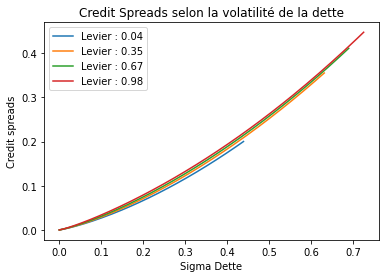

In [236]:
V_arr = [1/x for x in np.linspace(0.04, 0.98, 4)]
F = 1
T = 5
r = 0.05
sigmaV_array = np.linspace(0.01, 1.5 , 150)
for V in V_arr:
    plt.plot([f_sigmaD2(V, F, tmp, r, T) for tmp in sigmaV_array], [f_get_creditSpread2(V, F, r, tmp, T) for tmp in sigmaV_array], label = f"Levier : {round(1/V, 2)}")
plt.legend()
plt.title("Credit Spreads selon la volatilité de la dette")
plt.ylabel("Credit spreads")
plt.xlabel("Sigma Dette")

## Question 2

In [2]:
# Import trace
import pandas as pd
df = pd.read_csv("/Users/sebastiencaron/Fixed-Income/Cours 6/Trace.csv")

## Les data sont déjà cleané

In [11]:
df.loc[df["RATING_1"].isna() & df["RATING_2"].isna() & df["RATING_3"].isna(), :]
# Ils ont tous des ratings

,ASCII_RPTD_VOL_TX,ASOF_CD,CUSIP_ID_NUM,MSG_SEQ_NB,ORIG_MSG_SEQ_NB,RATING_1,RATING_2,RATING_3,RPTD_PR,TRC_ST,TRD_EXCTN_DT,TRD_EXCTN_TM,TTM,YLD_OWN,YLD_PT,YLD_SPREAD


In [ ]:
diction_name = {"ASCII_RPTD_VOL_TX" : "Quantity",
                "ASOF_CD" :"As Of Indicator",
                "CUSIP_ID_NUM" : "Cusip",
                "MSG_SEQ_NB": "Message Sequence Number",
                "ORIG_MSG_SEQ_NB": "Original Message Sequence Number",
                "RATING_1": "S&P",
                "RATING_2": "Moody's",
                "RATING_3": "Fitch",
                "RPTD_PR": "Price",
                "TRC_ST" :"Trade Status",
                "TRD_EXCTN_DT": "Execution Date",
                "TRD_EXCTN_TM": "Execution Time",
                "TTM" : "Time to maturity",
                "YLD_OWN": ,
                "YLD_PT": "Yield" , 
                "YLD_SPREAD" : 
                     }

In [27]:
def convert_to_float(s):
    # Convert the string to a complex number
    complex_num = complex(s.replace('i', 'j'))  # Replace 'i' with 'j' for Python compatibility
    # Extract the real part and round to 6 decimal places
    return round(complex_num.real, 6)

In [38]:
from matplotlib import pyplot as plt
df["YLD_OWN"] = df["YLD_OWN"].apply(convert_to_float)

In [43]:
# Download liquidity data to have id
liquidity = pd.read_excel("/Users/sebastiencaron/Fixed-Income/Cours 6/Liquidity.xlsx")

In [49]:
liquidity_clean = liquidity.iloc[:, :33]

In [157]:
print(f"Dataset from {liquidity['SPREAD_M_M'].min()} to {liquidity['SPREAD_M_M'].max()}")

Dataset from 200501 to 201105


In [106]:
# First, create a combined identifier in both DataFrames
df_clean['combined_id'] = df_clean['CUSIP_ID_NUM'].astype(str) + '_' + df_clean['Date_M'].astype(str)

liquidity_clean['combined_id'] = liquidity_clean['SPREAD_M_ID'].astype(str) + '_' + liquidity_clean['SPREAD_M_M'].astype(str)

# Now, filter 'df' based on this combined identifier
df_clean2 = df_clean[df_clean['combined_id'].isin(liquidity_clean['combined_id'])]

In [91]:
# Function to extract YearMonth from date
def extract_year_month(date):
    return str(date)[:6]
df_clean["Date_M"] = df_clean["TRD_EXCTN_DT"].apply(extract_year_month)

/var/folders/hv/1_92kz110w572ncggsb_c81c0000gp/T/ipykernel_38821/1905895338.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["Date_M"] = df_clean["TRD_EXCTN_DT"].apply(extract_year_month)


In [101]:

# Volatility : 
def calculate_volatility(x):
    return x.std() # * np.sqrt(252), no need to annualize



# Group by cusip_id and YearMonth, and apply the volatility calculation
# Group by 'CUSIP_ID_NUM' and 'Date_M', then apply multiple aggregation functions

volatility_df = df_clean.groupby(['CUSIP_ID_NUM', 'Date_M']).agg(
    VOLA_M=('YLD_OWN', calculate_volatility),  # Calculate volatility
    Observation_Count=('YLD_OWN', 'count')  # Count observations
).reset_index()

volatility_df["combined_id"] = volatility_df['CUSIP_ID_NUM'].astype(str) + '_' + volatility_df['Date_M'].astype(str)

In [104]:
# Volatility Adjusted 
volatility_df["VOLAADJ_M"] = volatility_df["VOLA_M"] * np.sqrt(4 * volatility_df["Observation_Count"]) # Should be 12 instead of 4, error in data of teacher

In [280]:
volatility_df2 = volatility_df[volatility_df["combined_id"].isin(liquidity_clean["combined_id"])]


In [138]:
# Merge the columns
liquidity[["VOLA_M", "VOLAADJ_M", "SPREAD_M_COUNT"]] = volatility_df2[["VOLA_M", "VOLAADJ_M", "Observation_Count"]].values

In [242]:
import openpyxl
liquidity.to_excel("/Users/sebastiencaron/Fixed-Income/Cours 6/liquidityVOL_Cash.xlsx", index=False, engine='openpyxl')

### Visualiser les données Volatilités

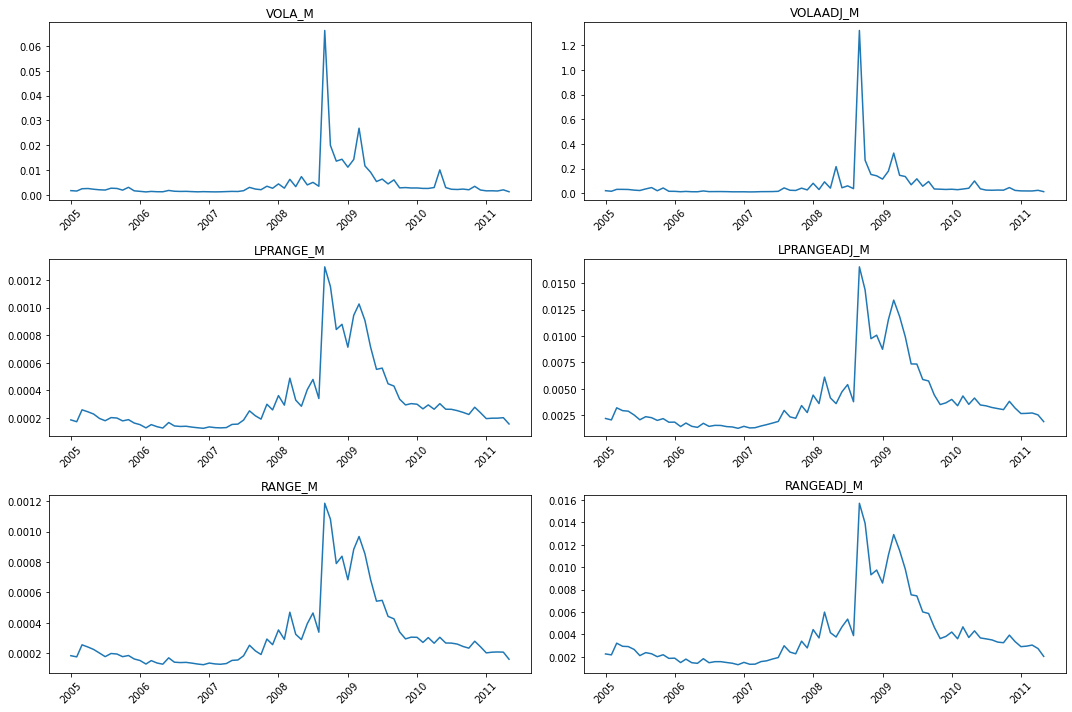

In [314]:
date_M = pd.to_datetime(liquidity["SPREAD_M_M"].astype(str), format="%Y%m")
col_vol_to_plot = ["VOLA_M", "VOLAADJ_M", "LPRANGE_M", "LPRANGEADJ_M", "RANGE_M", "RANGEADJ_M"]
volatility_graph = pd.DataFrame(data = liquidity[col_vol_to_plot])
volatility_graph.index = date_M
tmp = volatility_graph.groupby(volatility_graph.index).mean()

# Plotting
fig, axes = plt.subplots(3, 2, figsize=(15, 10)) # Adjust the figsize based on your needs
axes = axes.flatten()

for i, col in enumerate(col_vol_to_plot):
    axes[i].plot(tmp.index, tmp[col] / 100)
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [321]:
liquidity["decile"] = pd.qcut(liquidity["VOLAADJ_M"], 10, labels=False)


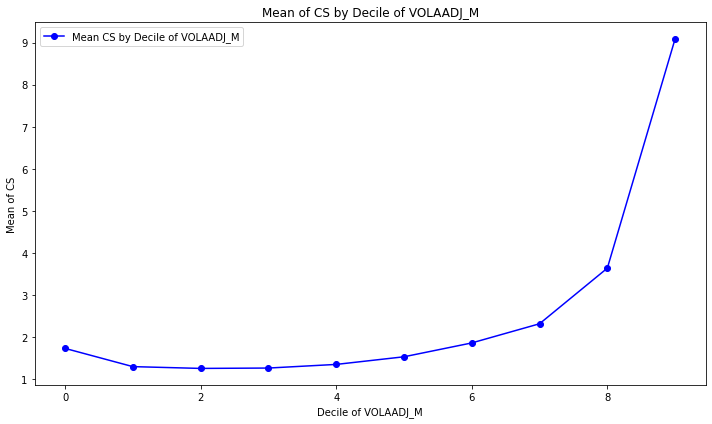

In [322]:
# Credit spread and bond volatility

# Sorting the sample into deciles based on "VOLAADJ_M"
liquidity["decile"] = pd.qcut(liquidity["VOLAADJ_M"], 10, labels=False)

# Calculating the mean of each subsample for both "CS" and "VOLAADJ_M"
mean_by_decile = liquidity.groupby("decile").mean()

# Plotting the mean of "CS" for each decile of "VOLAADJ_M"
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(mean_by_decile.index, mean_by_decile["CS"], marker='o', linestyle='-', color='blue', label='Mean CS by Decile of VOLAADJ_M')

ax.set_xlabel("Decile of VOLAADJ_M")
ax.set_ylabel("Mean of CS")
ax.set_title("Mean of CS by Decile of VOLAADJ_M")
ax.legend()

plt.tight_layout()
plt.show()

## Campell indicators

In [ ]:
# Get ID of issuer to retreive on compustats and CRSP

for x in ["GVKEY", "PERMNO"]:
    unique_gvkeys = liquidity[x].unique()

    # Save the array to a text file
    np.savetxt("unique_" + x + ".txt", unique_gvkeys, fmt='%s', newline='\n')

In [200]:
# Importer Compustats data :
campbell_fundamentals = pd.read_csv("/Users/sebastiencaron/Fixed-Income/TP/Compustat_Q2_2.csv")

campbell_fundamentals["datadate"] = pd.to_datetime(campbell_fundamentals["datadate"])

# Ajouter 2 mois et 1 jour à chaque date (Pour être certain que les données sont disponibles)
campbell_fundamentals['Date_M'] = campbell_fundamentals['datadate'] + pd.DateOffset(days=1) + pd.DateOffset(months=2)
campbell_fundamentals["Date_M"] = campbell_fundamentals["Date_M"].astype(str).str[:4] + campbell_fundamentals["Date_M"].astype(str).str[5:7]
cols_to_keep = ["gvkey", "datadate", "Date_M", "atq", "cheq", "ltq"]
colname = ["gvkey", "datadate", "Date_M", "Total Assets", "Cash", "Liabilities"]
campbell_fundamentals = campbell_fundamentals[cols_to_keep]
campbell_fundamentals.columns = colname

campbell_fundamentals["CASHMTA"] = campbell_fundamentals["Cash"] / campbell_fundamentals["Total Assets"]
campbell_fundamentals

,gvkey,datadate,Date_M,Total Assets,Cash,Liabilities,CASHMTA
0,1004,2004-08-31,200411,699.304,26.802,396.102,0.038327
1,1004,2004-11-30,200502,710.927,19.667,399.798,0.027664
2,1004,2005-02-28,200505,707.467,32.091,391.101,0.045360
3,1004,2005-05-31,200508,732.230,50.338,417.486,0.068746
4,1004,2005-08-31,200511,757.826,24.411,437.924,0.032212
...,...,...,...,...,...,...,...
10580,211819,2010-03-31,201006,66139.586,3214.876,59744.762,0.048607
10581,211819,2010-06-30,201009,NaN,NaN,NaN,NaN
10582,211819,2010-09-30,201012,71351.097,5269.885,60487.268,0.073859
10583,211819,2010-12-31,201103,NaN,NaN,NaN,NaN


In [239]:

# Supposons que campbell_fundamentals et liquidity sont déjà définis
# Assurez-vous que Date_M est au format datetime dans les deux DataFrames

def f_returnCASHMTA(row, campbell_fundamentals):
    # Extrayez Date_M et gvkey de la ligne
    Date_M = row['SPREAD_M_M']  # Assurez-vous que Date_M est une chaîne ou datetime
    gvkey = row['GVKEY']
    
    # Filtrez campbell_fundamentals comme avant
    tmp = campbell_fundamentals[(campbell_fundamentals["Date_M"] <= str(Date_M)) & (campbell_fundamentals["gvkey"] == gvkey)]
    
    # Appliquez la logique précédente
    if not tmp.empty and pd.isna(tmp.iloc[-1]["CASHMTA"]):
        return tmp.iloc[-2]["CASHMTA"] if len(tmp) > 1 else None  # Retourne None si tmp a moins de 2 lignes
    elif not tmp.empty:
        return tmp.iloc[-1]["CASHMTA"]
    else:
        return None  # Retourne None si tmp est vide

# Utilisez .apply avec axis=1 pour appliquer la fonction à chaque ligne
liquidity['CASHMTA'] = liquidity.apply(f_returnCASHMTA, campbell_fundamentals=campbell_fundamentals, axis=1)


In [268]:
columns_liquidity_5 = ["LIQ_M_A", "LIQ_M_A_risk", "LIQ_M_I", "LIQ_M_I_risk", "LIQ_M_R"]
lambda_5 = (liquidity[columns_liquidity_5] - liquidity[columns_liquidity_5].mean()) / liquidity[columns_liquidity_5].std() 
lambda_5_col = lambda_5.sum(axis = 1)

In [273]:
columns_Campbell = ["NIMTAAVG", "TLMTA", "EXRETAVG", "SIGMA", "RSIZE", "CASHMTA", "MB", "PRICE"]

# Normalize the selected columns in the DataFrame
pi = (liquidity[columns_Campbell] - liquidity[columns_Campbell].mean()) / liquidity[columns_Campbell].std()

pi = pi.fillna(0)
# Be careful with the sign : NIMTAAVG -, TLMTA+, EXRETAVG-, SIGMA+, RSIZE+, CASHMTA-, MB+, PRICE-
liquidity["Pi"] = -pi["NIMTAAVG"] + pi["TLMTA"] - pi["EXRETAVG"] + pi["SIGMA"] + pi["RSIZE"] - pi["CASHMTA"] + pi["MB"] - pi["PRICE"]

### Visualiser les données de liquidity

## Effectuer les régressions